## Capston Project

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import cv2
from tqdm import tqdm
os.environ['KERAS_BACKEND']='tensorflow'
import keras as k
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Process training data and unlabeled submission data

In [2]:
IMAGE_SIZE=128
NUM_CLASSES = 17

x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('./train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('./data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(NUM_CLASSES)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.
print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [00:40<00:00, 995.24it/s] 


(40479, 128, 128, 3)
(40479, 17)


In [3]:
from pathlib import Path
x_out = []
filenames_out = []
df_test = pd.read_csv('./sample_submission_v2.csv')

for f, tags in tqdm(df_test.values, miniters=1000):
    img = cv2.imread('./data/test-jpg/{}.jpg'.format(f))
    file = Path('./data/test-jpg/{}.jpg'.format(f))
    if file.exists():
        x_out.append(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)))
        filenames_out.append(f)
    else:
        print(file)
                                                                        
    
x_out = np.array(x_out, np.float16) / 255.
print(x_out.shape)

100%|██████████| 61191/61191 [01:01<00:00, 997.55it/s] 


(61191, 128, 128, 3)


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)

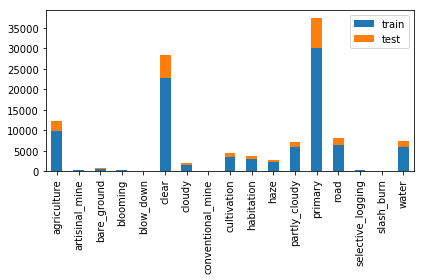

{'partly_cloudy': 5844, 'cloudy': 1686, 'agriculture': 9950, 'conventional_mine': 81, 'blooming': 260, 'primary': 29977, 'cultivation': 3560, 'blow_down': 75, 'road': 6490, 'selective_logging': 285, 'haze': 2177, 'habitation': 2927, 'bare_ground': 698, 'artisinal_mine': 268, 'water': 5941, 'slash_burn': 171, 'clear': 22676}
{'partly_cloudy': 1417, 'cloudy': 403, 'agriculture': 2365, 'conventional_mine': 19, 'blooming': 72, 'primary': 7536, 'cultivation': 917, 'blow_down': 23, 'road': 1581, 'selective_logging': 55, 'haze': 520, 'habitation': 733, 'bare_ground': 164, 'artisinal_mine': 71, 'water': 1470, 'slash_burn': 38, 'clear': 5755}


In [44]:
from collections import defaultdict, OrderedDict
train_labels_cnt = {}
valid_labels_cnt = {}
for key in label_map:
    train_labels_cnt[key] = 0
    valid_labels_cnt[key] = 0
    
def collect_labels(y, out):
    for train_tag in y:
        for idx in range(NUM_CLASSES):
            if train_tag[idx] == 1:
                out[inv_label_map[idx]] += 1
collect_labels(y_train, train_labels_cnt)
collect_labels(y_valid, valid_labels_cnt)

labels_cnt = defaultdict(list)
for key in train_labels_cnt:
    labels_cnt[key].append(train_labels_cnt[key])
    labels_cnt[key].append(valid_labels_cnt[key])

labels_df = pd.DataFrame.from_dict(labels_cnt)
labels_df.T.plot(kind='bar', stacked=True)
plt.legend(['train', 'test'])
plt.tight_layout()
#plt.savefig('labels.pdf')
plt.show()
print(train_labels_cnt)
print(valid_labels_cnt)

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.utils import plot_model

## Baseline Model

In [35]:
baseline_model = Sequential()
baseline_model.add(Conv2D(96, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
baseline_model.add(MaxPooling2D(pool_size=(3, 3)))
baseline_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
baseline_model.add(MaxPooling2D(pool_size=(3, 3)))
baseline_model.add(Flatten())
baseline_model.add(Dense(384, activation='relu'))
baseline_model.add(Dropout(0.7))
baseline_model.add(Dense(192, activation='relu'))
baseline_model.add(Dropout(0.7))
baseline_model.add(Dense(NUM_CLASSES, activation='sigmoid'))
plot_model(baseline_model, to_file='baseline_model.png')

In [8]:
def f2_score_metrics(y_true, y_pred, threshold_shift=0):
    beta = 2
    # just in case of hipster activation at the final layer
    y_pred = k.backend.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = k.backend.round(y_pred + threshold_shift)

    tp = k.backend.sum(k.backend.round(y_true * y_pred_bin), axis=1) + k.backend.epsilon()
    fp = k.backend.sum(k.backend.round(k.backend.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = k.backend.sum(k.backend.round(k.backend.clip(y_true - y_pred_bin, 0, 1)), axis=1)

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    beta_squared = beta ** 2
    return k.backend.mean((beta_squared + 1) * (p * r) / (beta_squared * p + r + k.backend.epsilon()))

In [36]:
adam_opt=Adam(lr=0.001)
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
             ModelCheckpoint('weights_baseline_cnn.hdf5', monitor='val_loss', save_best_only=True, verbose=0)]

baseline_model.compile(adam_opt, 'binary_crossentropy', ['accuracy', f2_score_metrics])
baseline_history = baseline_model.fit(x_train, y_train, batch_size=128, epochs=50,
                   validation_data=(x_valid, y_valid), callbacks=callbacks, shuffle=True)

Train on 32383 samples, validate on 8096 samples
Epoch 1/50
32383/32383 [==============================] - 51s - loss: 0.2762 - acc: 0.8951 - f2_score_metrics: 0.6312 - val_loss: 0.2051 - val_acc: 0.9200 - val_f2_score_metrics: 0.7063
Epoch 2/50
32383/32383 [==============================] - 48s - loss: 0.2200 - acc: 0.9149 - f2_score_metrics: 0.6760 - val_loss: 0.1954 - val_acc: 0.9213 - val_f2_score_metrics: 0.6960
Epoch 3/50
32383/32383 [==============================] - 48s - loss: 0.2070 - acc: 0.9175 - f2_score_metrics: 0.6896 - val_loss: 0.1839 - val_acc: 0.9240 - val_f2_score_metrics: 0.7298
Epoch 4/50
32383/32383 [==============================] - 48s - loss: 0.1973 - acc: 0.9204 - f2_score_metrics: 0.7005 - val_loss: 0.1801 - val_acc: 0.9253 - val_f2_score_metrics: 0.7068
Epoch 5/50
32383/32383 [==============================] - 47s - loss: 0.1888 - acc: 0.9241 - f2_score_metrics: 0.7204 - val_loss: 0.1684 - val_acc: 0.9326 - val_f2_score_metrics: 0.7485
Epoch 6/50
32383/3238

In [37]:
import matplotlib.pyplot as plt
def plot_model_stats(model_history, model_name):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title(model_name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1, 3, 2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(model_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1, 3, 3)
    plt.plot(model_history.history['f2_score_metrics'])
    plt.plot(model_history.history['val_f2_score_metrics'])
    plt.title(model_name)
    plt.ylabel('f2 score')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

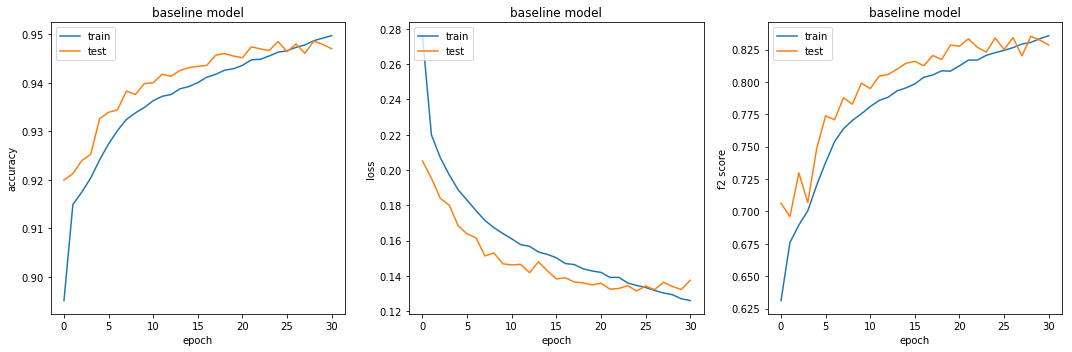

In [47]:
plot_model_stats(baseline_history, 'baseline model')
plt.tight_layout()
plt.show()
#plt.savefig('baseline_metrics.pdf')

In [39]:
def prob_threshold_optimizer(y_true, y_pred_prob):
    threshold=[]
    for idx in range(NUM_CLASSES):
        y=y_true[:,idx]
        yp = y_pred_prob[:,idx]
        scr=[]
        for th in np.linspace(0.01,0.99,20):
            yp_bin = (yp>th).astype(int)
            scr.append([th,fbeta_score(y,yp_bin, beta=2)])
        scr = np.array(scr)
        threshold.append( scr[:,0][np.argmax(scr[:,1])])
    return np.array(threshold)

In [13]:
from sklearn.metrics import fbeta_score
def f2_score(y_true, y_pred):
    # fbeta_score throws a confusing error if inputs are not numpy arrays
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    y_pred=(y_pred>0.5).astype(int)
    # We need to use average='samples' here, any other average method will generate bogus results
    return fbeta_score(y_true, y_pred, beta=2, average='samples')

In [14]:
baseline_model.load_weights('weights_baseline_cnn.hdf5')
y_pred_prob_train_baseline = baseline_model.predict(x_train)
y_pred_prob_val_baseline = baseline_model.predict(x_valid)

In [15]:
def f2_score_improved(y, y_pred, threshold):
    y_pred_ = (y_pred > threshold).astype(int)
    f2_score_labels = {}
    for idx in range(NUM_CLASSES):
        y_idx = y[:,idx]
        y_pred_idx_ = y_pred_[:,idx]
        f2_score_label = fbeta_score(y_idx, y_pred_idx_, beta=2)
        f2_score_labels[inv_label_map[idx]] = f2_score_label
    return f2_score(y, y_pred_), f2_score_labels

In [16]:
def print_label_threshold(threshold):
    for idx in range(NUM_CLASSES):
        print(inv_label_map[idx], threshold[idx])

In [40]:
baseline_threshold = prob_threshold_optimizer(y_train, y_pred_prob_train_baseline)
print_label_threshold(baseline_threshold)
baseline_train_f2, baseline_f2_train_labels = f2_score_improved(y_train, y_pred_prob_train_baseline, baseline_threshold)
baseline_val_f2, baseline_f2_val_labels = f2_score_improved(y_valid, y_pred_prob_val_baseline, baseline_threshold)

print('F2 score on training set: %.6f and on testing set %.6f' % (baseline_train_f2, baseline_val_f2))
print(baseline_f2_train_labels)
print(baseline_f2_val_labels)

/home/wengyao04/miniconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


partly_cloudy 0.267894736842
cloudy 0.267894736842
agriculture 0.216315789474
conventional_mine 0.0615789473684
blooming 0.0615789473684
selective_logging 0.0615789473684
cultivation 0.164736842105
blow_down 0.01
road 0.216315789474
water 0.164736842105
haze 0.164736842105
primary 0.267894736842
habitation 0.164736842105
artisinal_mine 0.216315789474
clear 0.216315789474
bare_ground 0.0615789473684
slash_burn 0.0615789473684
F2 score on training set: 0.894239 and on testing set 0.874115
{'partly_cloudy': 0.94059405940594054, 'cloudy': 0.87249390049856801, 'agriculture': 0.87083141938447406, 'conventional_mine': 0.19327731092436976, 'blooming': 0.31570426335671886, 'habitation': 0.70384721837807918, 'cultivation': 0.63121682720660499, 'blow_down': 0.11228230980751604, 'road': 0.81044718153573025, 'selective_logging': 0.43323863636363635, 'haze': 0.76138708141564848, 'primary': 0.98861958702143016, 'artisinal_mine': 0.74101247248716062, 'water': 0.67412746585735961, 'bare_ground': 0.3804

In [18]:
def generate_submission_file(predicted_label, filenames, fname):
    img_name=[]
    labels = []
    for i in range(61191):
        tmp = []
        for id in range(NUM_CLASSES):
            if predicted_label[i][id] == 1:
                tmp.append(inv_label_map[id])
        label = ' '.join(tmp)
        labels.append(label)
    
    df= pd.DataFrame({'image_name': filenames, 'tags': labels})
    df.to_csv(fname, index=False)

In [41]:
y_pred_prob_out_baseline = baseline_model.predict(x_out)
y_pred_out_binary_baseline = (y_pred_prob_out_baseline>baseline_threshold).astype(int)
generate_submission_file(y_pred_out_binary_baseline, filenames_out, 'submission_baseline.csv')

## Transfer Learning

In [20]:
def inception_model(addDropout=False):
    inputs=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    x=InceptionV3(weights='imagenet', include_top=False)(inputs)
    x=Flatten()(x)
    if addDropout:
        x=Dense(256, activation='relu')(x)
        x=Dropout(0.5)(x)
        x=Dense(NUM_CLASSES, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=x)

model = inception_model(addDropout=True)
plot_model(model, to_file='inceptionv3_model.png')

In [21]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range=180,
                             width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2,
                             horizontal_flip = True, vertical_flip = True,
                             fill_mode='nearest')

In [22]:
img = load_img('data/train-jpg/train_9252.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='.', save_prefix='train_9252', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [23]:
adam_opt=Adam(lr=0.0005)
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
             ModelCheckpoint('weights_final_layer_dropout.hdf5', monitor='val_loss', save_best_only=True, verbose=0)]
for layer in model.layers:
        layer.trainable=False
model.layers[-1].trainable=True
model.compile(adam_opt, 'binary_crossentropy', ['accuracy', f2_score_metrics])
inception_history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128), epochs=50, steps_per_epoch=252, 
                    validation_data=(x_valid, y_valid), callbacks=callbacks)

Epoch 1/50
252/252 [==============================] - 74s - loss: 0.4146 - acc: 0.8519 - f2_score_metrics: 0.5638 - val_loss: 0.3452 - val_acc: 0.9077 - val_f2_score_metrics: 0.6466
Epoch 2/50
252/252 [==============================] - 70s - loss: 0.3067 - acc: 0.9021 - f2_score_metrics: 0.6376 - val_loss: 0.3051 - val_acc: 0.9084 - val_f2_score_metrics: 0.6524
Epoch 3/50
252/252 [==============================] - 69s - loss: 0.2852 - acc: 0.9045 - f2_score_metrics: 0.6484 - val_loss: 0.2874 - val_acc: 0.9089 - val_f2_score_metrics: 0.6536
Epoch 4/50
252/252 [==============================] - 69s - loss: 0.2747 - acc: 0.9059 - f2_score_metrics: 0.6535 - val_loss: 0.2763 - val_acc: 0.9097 - val_f2_score_metrics: 0.6593
Epoch 5/50
252/252 [==============================] - 73s - loss: 0.2686 - acc: 0.9063 - f2_score_metrics: 0.6557 - val_loss: 0.2696 - val_acc: 0.9100 - val_f2_score_metrics: 0.6604
Epoch 6/50
252/252 [==============================] - 71s - loss: 0.2645 - acc: 0.9066 - f

252/252 [==============================] - 69s - loss: 0.2362 - acc: 0.9079 - f2_score_metrics: 0.6635 - val_loss: 0.2257 - val_acc: 0.9118 - val_f2_score_metrics: 0.6682
Epoch 46/50
252/252 [==============================] - 70s - loss: 0.2363 - acc: 0.9082 - f2_score_metrics: 0.6639 - val_loss: 0.2252 - val_acc: 0.9119 - val_f2_score_metrics: 0.6707
Epoch 47/50
252/252 [==============================] - 68s - loss: 0.2372 - acc: 0.9071 - f2_score_metrics: 0.6613 - val_loss: 0.2253 - val_acc: 0.9121 - val_f2_score_metrics: 0.6690
Epoch 48/50
252/252 [==============================] - 69s - loss: 0.2369 - acc: 0.9078 - f2_score_metrics: 0.6625 - val_loss: 0.2252 - val_acc: 0.9118 - val_f2_score_metrics: 0.6684
Epoch 49/50
252/252 [==============================] - 69s - loss: 0.2353 - acc: 0.9083 - f2_score_metrics: 0.6643 - val_loss: 0.2250 - val_acc: 0.9118 - val_f2_score_metrics: 0.6683
Epoch 50/50
252/252 [==============================] - 69s - loss: 0.2360 - acc: 0.9080 - f2_scor

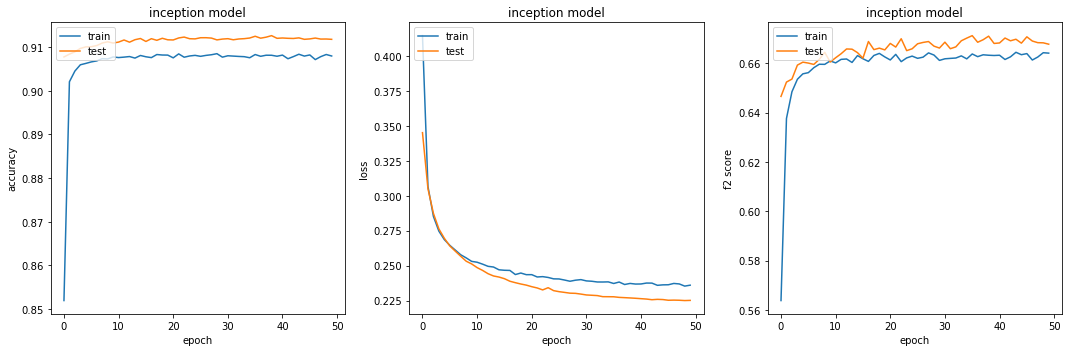

In [51]:
plot_model_stats(inception_history, 'inception model')
plt.tight_layout()
#plt.savefig("inception_metrics.pdf")
plt.show()

In [25]:
model.load_weights('weights_final_layer_dropout.hdf5')
for layer in model.layers:
    layer.trainable=True
adam_opt=Adam(lr=0.0001)
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
             ModelCheckpoint('weights_all_layer_dropout.hdf5', monitor='val_loss', save_best_only=True, verbose=0)]

model.compile(adam_opt, 'binary_crossentropy', ['accuracy', f2_score_metrics])
inception_all_history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128), 
                                            epochs=50, steps_per_epoch=252, 
                                            validation_data=(x_valid, y_valid),
                                            callbacks=callbacks)

Epoch 1/50
252/252 [==============================] - 143s - loss: 0.1574 - acc: 0.9401 - f2_score_metrics: 0.8014 - val_loss: 0.1213 - val_acc: 0.9533 - val_f2_score_metrics: 0.8611
Epoch 2/50
252/252 [==============================] - 129s - loss: 0.1284 - acc: 0.9522 - f2_score_metrics: 0.8465 - val_loss: 0.1092 - val_acc: 0.9582 - val_f2_score_metrics: 0.8831
Epoch 3/50
252/252 [==============================] - 128s - loss: 0.1207 - acc: 0.9549 - f2_score_metrics: 0.8558 - val_loss: 0.1005 - val_acc: 0.9619 - val_f2_score_metrics: 0.8847
Epoch 4/50
252/252 [==============================] - 128s - loss: 0.1159 - acc: 0.9568 - f2_score_metrics: 0.8630 - val_loss: 0.1016 - val_acc: 0.9618 - val_f2_score_metrics: 0.8858
Epoch 5/50
252/252 [==============================] - 128s - loss: 0.1129 - acc: 0.9580 - f2_score_metrics: 0.8680 - val_loss: 0.0968 - val_acc: 0.9632 - val_f2_score_metrics: 0.8896
Epoch 6/50
252/252 [==============================] - 128s - loss: 0.1114 - acc: 0.95

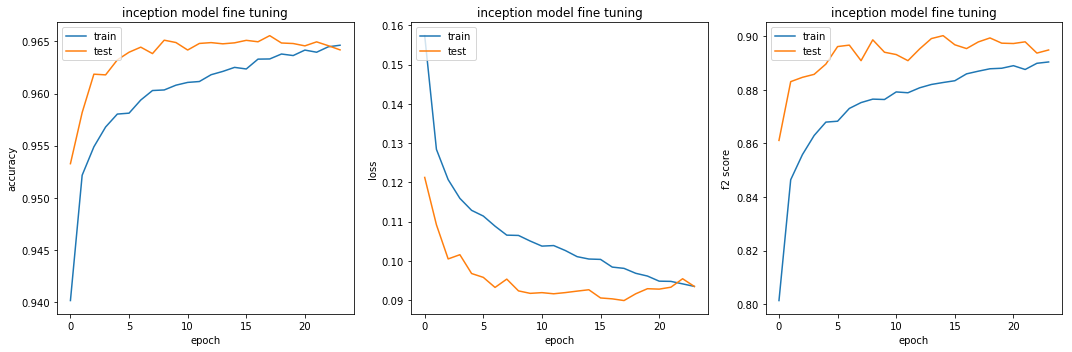

In [54]:
plot_model_stats(inception_all_history, 'inception model fine tuning')
plt.tight_layout()
#plt.savefig("inception_finetune_metrics.pdf")
plt.show()

In [27]:
model.load_weights('weights_all_layer_dropout.hdf5')
y_pred_prob_train= model.predict(x_train)
y_pred_prob_val = model.predict(x_valid)
y_pred_prob_out= model.predict(x_out)

In [28]:
threshold = prob_threshold_optimizer(y_train, y_pred_prob_train)
print_label_threshold(threshold)
train_f2, f2_train_labels = f2_score_improved(y_train, y_pred_prob_train, threshold)
val_f2, f2_val_labels = f2_score_improved(y_valid, y_pred_prob_val, threshold)

print('F2 score on training set: %.6f and on testing set %.6f' % (train_f2, val_f2))
print(f2_train_labels)
print(f2_val_labels)

/home/wengyao04/miniconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


partly_cloudy 0.216315789474
cloudy 0.164736842105
agriculture 0.164736842105
conventional_mine 0.216315789474
blooming 0.113157894737
selective_logging 0.113157894737
cultivation 0.164736842105
blow_down 0.113157894737
road 0.216315789474
water 0.164736842105
haze 0.164736842105
primary 0.319473684211
habitation 0.164736842105
artisinal_mine 0.216315789474
clear 0.164736842105
bare_ground 0.0615789473684
slash_burn 0.0615789473684
F2 score on training set: 0.928658 and on testing set 0.920617
{'partly_cloudy': 0.9520149702599745, 'cloudy': 0.90514813563140695, 'agriculture': 0.9027527802512173, 'conventional_mine': 0.71601941747572817, 'blooming': 0.42923433874709976, 'habitation': 0.76710955126598157, 'cultivation': 0.6957272133594552, 'blow_down': 0.46692607003891046, 'road': 0.86725227575810293, 'selective_logging': 0.52998965873836612, 'haze': 0.81147677915135319, 'primary': 0.99098322043007181, 'artisinal_mine': 0.86559532505478465, 'water': 0.82709957254211708, 'bare_ground': 0.

/home/wengyao04/miniconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [29]:
y_pred_out_binary = (y_pred_prob_out>threshold).astype(int)
generate_submission_file(y_pred_out_binary, filenames_out, 'submission_augment_full_dropout.csv')

In [30]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, idx, title, classes = ['F', 'T'], cmap=plt.cm.Oranges):
    plt.subplot(3, 6, idx+1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.yticks(tick_marks, classes)
    plt.xticks(tick_marks, classes, rotation=45)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

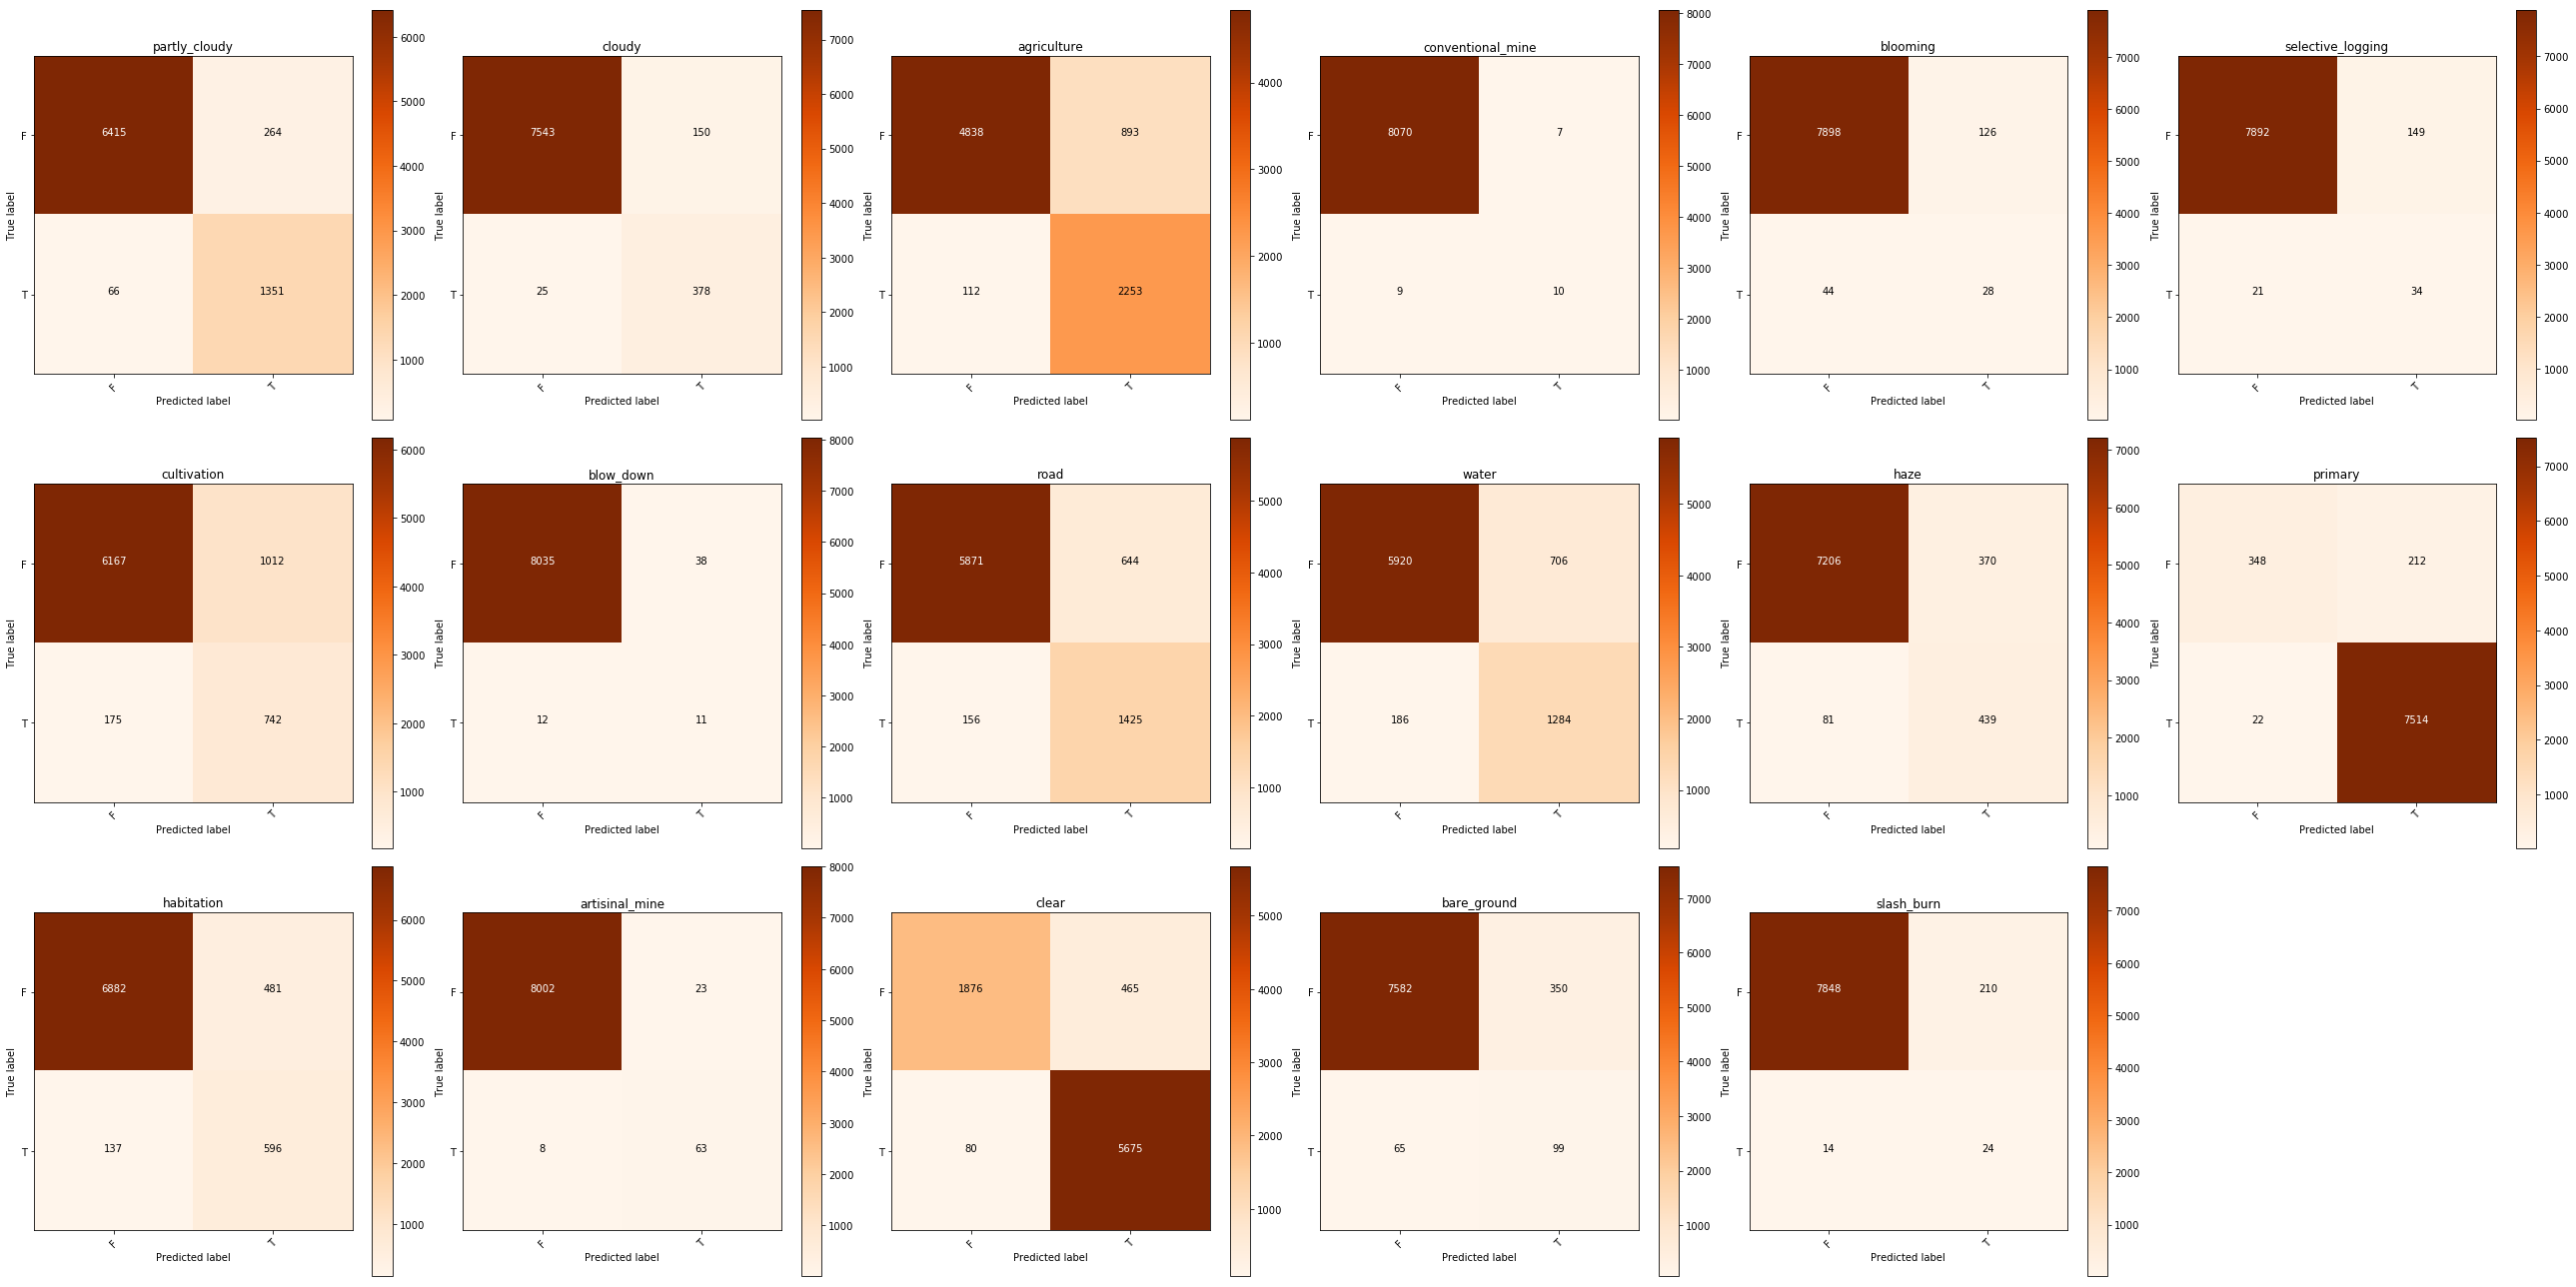

In [57]:
y_pred_binary_val=(y_pred_prob_val>threshold).astype(int)
plt.figure(figsize=(36, 18))
for idx in range(NUM_CLASSES):
    # Compute confusion matrix
    y_label_true = y_valid[:,idx]
    y_label_pred = y_pred_binary_val[:,idx]
    #print (inv_label_map[idx])
    #print (np.sum(y_label_true, axis=0))
    cnf_matrix = confusion_matrix(y_valid[:,idx], y_pred_binary_val[:,idx])
    #cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    #cnf_matrix = confusion_matrix(test, test_)
    #np.set_printoptions(precision=2)
    
    plot_confusion_matrix(cnf_matrix, idx, inv_label_map[idx])
plt.show()
#plt.savefig('label_cf.pdf')